In [35]:
import pandas as pd
import numpy as np
import torch
from PIL import Image
import cv2
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [36]:
df = pd.read_pickle("LSWMD.pkl")
print(df)

                                                 waferMap  dieSize   lotName  \
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
...                                                   ...      ...       ...   
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...    600.0  lot47542   
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...    600.0  lot47543   
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47543   

        waferIndex trianTestLabel    fa

In [37]:
#Process on the wafermap
wafermap = np.asarray(df.waferMap)
dim = (64, 64)
for i in range(len(wafermap)):
    wafermap[i] = cv2.resize(wafermap[i],dim,interpolation = cv2.INTER_AREA)
    wafermap[i] = np.reshape(wafermap[i],(1,64,64))


In [38]:
#Process on the train_test_label
label_map = {'Training':1,'Test':2}
df=df.replace({'trianTestLabel':label_map})
label = np.asarray(df.trianTestLabel)
print(label)

[1 1 1 ... 2 array([], shape=(0, 0), dtype=float64)
 array([], shape=(0, 0), dtype=float64)]


In [39]:
#Process on the failure type
failure_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureType':failure_type})
failure = np.asarray(df.failureType)
print(failure)

[8 8 8 ... 3 array([], shape=(0, 0), dtype=float64)
 array([], shape=(0, 0), dtype=float64)]


In [40]:
train_feature = []
train_label = []
test_feature = []
test_label = []

for i in range(len(wafermap)):
    if label[i] == 1:#Training label
        train_feature.append(wafermap[i])
        train_label.append(failure[i])
    elif label[i] == 2:#Testing label
        test_feature.append(wafermap[i])
        test_label.append(failure[i])

train_feature = np.asarray(train_feature)
train_label = np.asarray(train_label)
test_feature = np.asarray(test_feature)
test_label = np.asarray(test_label)
train_feature = torch.tensor(train_feature)
train_label = torch.tensor(train_label)
test_feature = torch.tensor(test_feature)
test_label = torch.tensor(test_label)

train_feature = train_feature.type(torch.float)
train_label = train_label.type(torch.float)
test_feature = test_feature.type(torch.float)
test_label = test_label.type(torch.float)


train_dataset = TensorDataset(train_feature,train_label)
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataset = TensorDataset(test_feature,test_label)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [41]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.6)
        )

        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 9)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_data):
        conv_1 = self.conv1(input_data)
        conv_2 = self.conv2(conv_1)
        conv_3 = self.conv3(conv_2)
        flat = torch.flatten(conv_3, 1)
        fully1 = self.fc1(flat)
        fully1_relu1 = self.relu(fully1)
        fully2 = self.fc2(fully1_relu1)
        fully2_relu2 = self.relu(fully2)
        fully3 = self.fc3(fully2_relu2)
        out = self.softmax(fully3)
        return out

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def load_model(self, save_path, is_state_dict=False):
        if not is_state_dict:
            saved_model = torch.load(save_path)
            self.load_state_dict(saved_model.state_dict())
        else:
            self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path, is_state_dict=False):
        if is_state_dict:
            torch.save(self.state_dict(), save_path)
        else:
            torch.save(self, save_path)


In [43]:
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(train_loader, leave=False, desc="Training Batches"):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        batch += 1
        output = model.forward(images)
        loss = model.compute_Loss(output,labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Training Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total



In [44]:
def evaluation(model, test_loader, optimizer):
    model.eval()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(test_loader, leave=False, desc="Testing Batches"):
        images, labels = images.to(device), labels.to(device)
        batch += 1
        optimizer.zero_grad()
        output = model.forward(images)
        loss = model.compute_Loss(output,labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predict = torch.max(output.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Testing Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total


In [45]:
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader, min_loss=0):
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    loss_values = [[],[]]
    acc = [[],[]]
    for epoch in trange(number_of_epochs, desc="Epochs"):
        cur_loss = train_epoch(model, train_loader, optimizer)
        loss_values[0].append(cur_loss[0])
        acc[0].append(cur_loss[1])
        cur_loss_val = evaluation(model, val_loader, optimizer)
        loss_values[1].append(cur_loss_val[0])
        acc[1].append(cur_loss_val[1])
    if cur_loss[0] <= min_loss: return loss_values
    return loss_values, acc

In [46]:
model = CNN().to(device)
loss_value, accuracy = train_and_evaluate(50, model, train_dataloader, test_dataloader, min_loss=0.02)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.8368955902799088
Training Accuracy: 0.7718701131450648


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.34873864481724426
Testing Accuracy: 0.9334373287238079


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.7138235441321398
Training Accuracy: 0.7958973415509153


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.297997805506429
Testing Accuracy: 0.9347190016442515


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.5578295503523858
Training Accuracy: 0.8325637015913899


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.2575277692400735
Testing Accuracy: 0.9395842995067246


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.4561184903299984
Training Accuracy: 0.8589826142949131


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.2328943279426155
Testing Accuracy: 0.9415236730047641


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.39198228961555287
Training Accuracy: 0.8791647502529666


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.21369332335376962
Testing Accuracy: 0.9436148235591719


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.3505630373016602
Training Accuracy: 0.8910311838837274


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1978268384253566
Testing Accuracy: 0.9463636746911759


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.3208607438008082
Training Accuracy: 0.8993468862110201


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.18497584412236595
Testing Accuracy: 0.9487752434756946


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2992214490051436
Training Accuracy: 0.9050501333823935


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.17319859171581597
Testing Accuracy: 0.9509591466756608


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2818304992008694
Training Accuracy: 0.9100174776929445


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1616464117059671
Testing Accuracy: 0.953396011636241


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.26524995288916053
Training Accuracy: 0.9153159782908656


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.15178487671965166
Testing Accuracy: 0.95563050718833


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2526053926140337
Training Accuracy: 0.9202097323153344


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.14430310729925722
Testing Accuracy: 0.9577216577427379


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.24020581151104553
Training Accuracy: 0.9251402814828442


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.13881923993152767
Testing Accuracy: 0.9591804038956111


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.23017864865178125
Training Accuracy: 0.9288749885015178


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1347390838884653
Testing Accuracy: 0.9598549685905814


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.22128483858414041
Training Accuracy: 0.9316898169441634


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.13129390696798424
Testing Accuracy: 0.9605295332855517


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.21236421702752362
Training Accuracy: 0.9349093919602612


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1281789819607732
Testing Accuracy: 0.9615413803280071


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2051352302557044
Training Accuracy: 0.9363628001103854


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.12565220796433804
Testing Accuracy: 0.96232556178591


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.19709106480874386
Training Accuracy: 0.9390672431239077


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.12296877061242278
Testing Accuracy: 0.9629916944221931


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.19239699762283527
Training Accuracy: 0.9409437954190046


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.12066437079898457
Testing Accuracy: 0.9636156667650407


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.18619776814343875
Training Accuracy: 0.942599576855855


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11843592560842046
Testing Accuracy: 0.9641974788144525


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.18231388699491885
Training Accuracy: 0.9432434918590746


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11667488978573769
Testing Accuracy: 0.9644588726337535


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.17793542504750162
Training Accuracy: 0.9451752368687333


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11503230613105536
Testing Accuracy: 0.9646781061596189


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.17540569370066378
Training Accuracy: 0.9459111397295557


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11342773986587244
Testing Accuracy: 0.9650238205657912


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.17017199056092067
Training Accuracy: 0.9471253794499126


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11227576990998553
Testing Accuracy: 0.965276782326405


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1677327452814536
Training Accuracy: 0.9471621745929537


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.11098551058118662
Testing Accuracy: 0.9656477929086387


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1645291054996757
Training Accuracy: 0.948486799742434


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1097501600962649
Testing Accuracy: 0.9658754584931911


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.16066156364089157
Training Accuracy: 0.9492411001747769


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10865304145529116
Testing Accuracy: 0.9661031240777436


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.15688783631177397
Training Accuracy: 0.9502713641799283


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10766345312734713
Testing Accuracy: 0.9663476537796704


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.15433168827246044
Training Accuracy: 0.9519271456167786


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1066814713088578
Testing Accuracy: 0.9665247270121


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.15151459731542485
Training Accuracy: 0.9523134946187103


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1057340046379157
Testing Accuracy: 0.9668704414182723


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.15078389091216168
Training Accuracy: 0.9521111213319842


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10479295085426306
Testing Accuracy: 0.9671992917070703


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.14665568618955604
Training Accuracy: 0.9534173489099439


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.103965339330074
Testing Accuracy: 0.9674775496437455


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.14412545101365903
Training Accuracy: 0.954079661484684


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1031244337920378
Testing Accuracy: 0.9676799190522366


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.14187224167121631
Training Accuracy: 0.9543556250574924


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10222316419215638
Testing Accuracy: 0.9679834731649732


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.13907449202177918
Training Accuracy: 0.9546315886303008


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10145698046242618
Testing Accuracy: 0.9681352502213415


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.13645279857626186
Training Accuracy: 0.956084996780425


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.10073474231132752
Testing Accuracy: 0.9682701631603357


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.13567851580531598
Training Accuracy: 0.9561401894949867


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09994639058244867
Testing Accuracy: 0.9682870272777099


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1316109522971965
Training Accuracy: 0.9570968632140557


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09921363859188108
Testing Accuracy: 0.9685484210970108


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.13109728924674127
Training Accuracy: 0.9575384049305492


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09832656204774658
Testing Accuracy: 0.9687845187402504


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.12984123769436365
Training Accuracy: 0.9575935976451109


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09753154715065107
Testing Accuracy: 0.9689868881487416


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1269812694594574
Training Accuracy: 0.9583846932204949


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09682859539170671
Testing Accuracy: 0.9691808254985455


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1240122434866323
Training Accuracy: 0.9598381013706191


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09611541325866828
Testing Accuracy: 0.9693831949070365


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.12343996105322798
Training Accuracy: 0.9602428479440713


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09542753239127229
Testing Accuracy: 0.9695771322568405


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.12097416938252883
Training Accuracy: 0.9603532333731948


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09471067030429975
Testing Accuracy: 0.9697963657827059


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11771892526412384
Training Accuracy: 0.9609419556618526


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.0940076888422317
Testing Accuracy: 0.9699228466630128


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11707656010636543
Training Accuracy: 0.9608315702327292


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09329396422249604
Testing Accuracy: 0.9701505122475652


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11563227970431292
Training Accuracy: 0.9621010026676479


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09262955555213027
Testing Accuracy: 0.9703528816560564


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11425255880773354
Training Accuracy: 0.9625793395271824


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09191550715099554
Testing Accuracy: 0.9704709304776761


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11138837030607165
Training Accuracy: 0.9630576763867169


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09126360291149778
Testing Accuracy: 0.9706058434166702


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.11006511350835192
Training Accuracy: 0.9637935792475393


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.09068821460491715
Testing Accuracy: 0.9708419410599097


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.1076560919599322
Training Accuracy: 0.9642719161070739


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.08995732946504546
Testing Accuracy: 0.9710021501749653


In [47]:
# save the training model
import os
path = os.getcwd()+"/cnn.pth"
model.save_model(path)

In [52]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.4, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2)

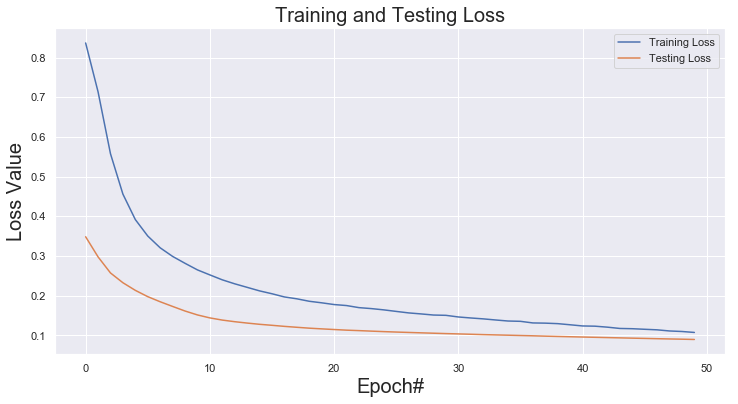

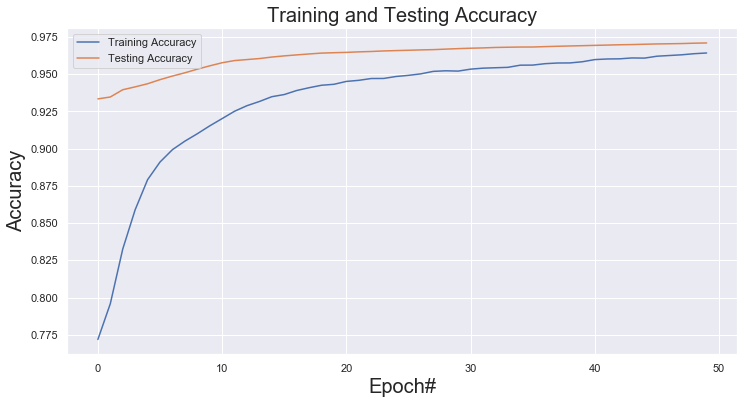

In [58]:
#plot the training and testing loss and accuracy
import matplotlib.pyplot as plt
train_loss = loss_value[0]
test_loss = loss_value[1]
train_accuracy = accuracy[0]
test_accuracy = accuracy[1]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_loss, label="Training Loss")
ax.plot(test_loss, label="Testing Loss")
ax.legend()
ax.set_xlabel("Epoch#", fontsize=20)
ax.set_ylabel("Loss Value", fontsize=20)
ax.set_title("Training and Testing Loss", fontsize=20)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_accuracy, label="Training Accuracy")
ax.plot(test_accuracy, label="Testing Accuracy")
ax.set_xlabel("Epoch#", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_title("Training and Testing Accuracy", fontsize=20)
ax.legend()
plt.show()

In [49]:
failure_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
failure_list = ["Center","Donut","Edge-Loc","Edge-Ring","Loc","Random","Scratch","Near-full","None"]

In [61]:
prediction = []
true = []
for images,labels in tqdm(test_dataloader, leave=False, desc="Testing Batches"):
    images, labels = images.to(device), labels.to(device)
    output = model.forward(images)
    _, predicted = torch.max(output.data, 1)
    for i in range(labels.shape[0]):
        prediction.append(predicted[i].item())
        true.append(labels[i].item())

Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

In [67]:
count = 0
for i in range(len(true)):
    if true[i] == prediction[i]:
        count += 1
print(count)
print(len(true))
print(count/len(true))

114549
118595
0.9658838905518783


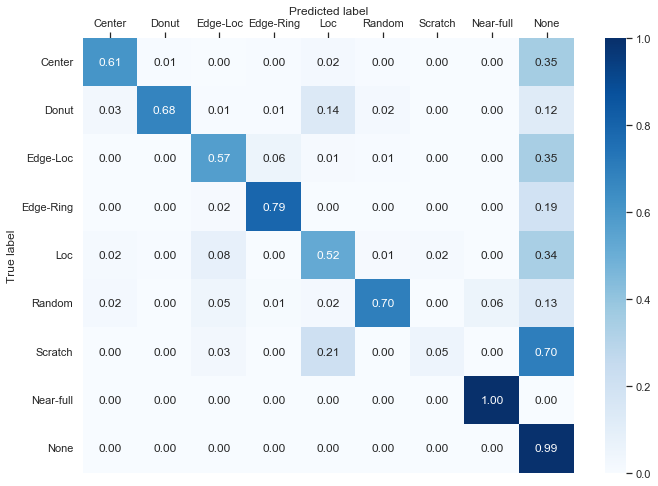

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(true, prediction)
cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
#print(cf_matrix)
sns.set(rc = {'figure.figsize':(11,8)})
ax = sns.heatmap(cmn,annot=True, fmt='.2f',xticklabels=failure_list,yticklabels=failure_list,cmap="Blues")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()